<a href="https://colab.research.google.com/github/SourLemon23/covid19-diagnosis/blob/master/COVID_19_CT_Diagnosis_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# ! pip install keras==2.2.0
# ! pip install tensorflow==1.10.0
# ! pip install keras==2.2.2 # EfficientNet PyPi
# ! pip install tensorflow==1.12.0 # EfficientNet PyPi

# Versions that are compatible with vis
# ! pip install keras==2.2.4
# ! pip install tensorflow==1.14.0
# ! pip install keras_applications >= 1.0.7
# https://stackoverflow.com/questions/57773636/no-attribute-set-keras-submodules

# ! pip install vis
# ! pip install scipy==1.1.0

In [23]:
import os
import numpy as np
import random

import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt

# EfficientNetB7
! pip install -U efficientnet
# ! pip install efficientnet
from efficientnet.tfkeras import EfficientNetB7

# Grad-CAM
import scipy
print('Using SciPy Version:', scipy.__version__) # Should be 1.1.0

Using TensorFlow Version: 2.3.0
Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.1.1)
Using SciPy Version: 1.4.1


In [24]:
# ! pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps
# import vis

# from vis.utils import utils
# from vis.visualization import visualize_cam

# --------------------------------------------
# FROM https://github.com/raghakot/keras-vis/blob/master/applications/self_driving/visualize_attention.ipynb
# --------------------------------------------
# for i, modifier in enumerate(modifiers):
#     heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, 
#                             seed_input=bgr_img, grad_modifier=modifier)
#     plt.figure()
#     plt.title(titles[i])
#     # Overlay is used to alpha blend heatmap onto img.
#     jet_heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)
#     plt.imshow(overlay(img, jet_heatmap, alpha=0.7))

In [25]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# # Upload files
# from google.colab import files
# files.upload()

In [27]:
# Initialize dataset directories (Google Drive)
# ct_training_dir   = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset/Training'
# ct_validation_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset/Validation'
# ct_testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset/Testing'

ct_training_dir   = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset - Copy/Training'
ct_validation_dir = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset - Copy/Validation'
ct_testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset - Copy/Testing'

In [28]:
# # Store all testing images in a list
# testing_img_paths = []

# for root, dirs, files in os.walk(testing_dir):
#     for filename in files:
#         testing_img_paths.append(os.path.abspath(os.path.join(root, filename)))

# # Randomize the list
# random.shuffle(testing_img_paths)

In [29]:
# Initialize constants
classes = ['COVID-19 Positive', 'COVID-19 Negative']
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

testing_set_start_index = -50
testing_set_end_index = 49

batch_size = 30
epochs = 3

In [30]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,
                                       featurewise_center=False, # Set input mean to 0 over dataset
                                       samplewise_center=False, # Set each sample mean to 0
                                       featurewise_std_normalization=False, # Divide inputs by std of dataset
                                       samplewise_std_normalization=False, # Divide each input by its std
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=0.15,
                                       shear_range=0.15,
                                       rotation_range=360,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       validation_split=0.15)

validation_data_gen = ImageDataGenerator(rescale=1./255)

testing_data_gen = ImageDataGenerator(rescale=1./255)

In [31]:
# Split data
training_generator = training_data_gen.flow_from_directory(ct_training_dir,
                                                           target_size=target_size,
                                                           class_mode='binary',
                                                           batch_size=batch_size,
                                                           shuffle=True)

#  SHUFFLE = TRUE??
validation_generator = validation_data_gen.flow_from_directory(ct_validation_dir,
                                                               target_size=target_size,
                                                               class_mode='binary',
                                                               batch_size=batch_size,
                                                               shuffle=False)

testing_generator = testing_data_gen.flow_from_directory(ct_testing_dir,
                                                         target_size = target_size,
                                                         class_mode='binary',
                                                         batch_size=batch_size,
                                                         shuffle=True)

Found 4015 images belonging to 2 classes.
Found 348 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [32]:
# # Create a neural network
# def create_model():
#     model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    
#     x = model.output
#     # x = GlobalAveragePooling2D()(x)
#     x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x) # Max pooling picks up more prominent, sharp features than average pooling
#     x = Dropout(0.5)(x)

#     # x = GlobalAveragePooling2D()(x)
#     # x = Dropout(0.5)(x)

#     x = Flatten()(x)

#     # x = Dropout(0.5)(x)

#     # x = Dense(128, activation="relu")(x)
#     # x = Dense(64, activation="relu")(x)
#     # x = Dense(32, activation="relu")(x)
#     x = Dense(16, activation="relu")(x)
#     x = Dense(1,  activation="relu")(x)

#     predictions = Dense(training_generator.num_classes, activation="softmax")(x)
    
#     model = Model(inputs=model.input, outputs=predictions)

#     return model

In [33]:
# from tensorflow.keras.layers.experimental import preprocessing


# def build_model(num_classes):
#     inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
#     x = img_augmentation(inputs)
#     model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

#     # Freeze the pretrained weights
#     model.trainable = False

#     # Rebuild top
#     x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
#     x = layers.BatchNormalization()(x)

#     top_dropout_rate = 0.2
#     x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#     outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

#     # Compile
#     model = tf.keras.Model(inputs, outputs, name="EfficientNet")
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
#     model.compile(
#         optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
#     )
#     return model

In [34]:
# Create a neural network
def create_model():
    # Instantiate a base model with pre-trained weights.
    base_model = EfficientNetB7(weights='imagenet', include_top=False, pooling="max", input_shape=input_shape)
    # Freeze the base model
    base_model.trainable = False
    
    input = Input(shape=input_shape)
    x = base_model(input, training=False)
    # x = model.output

    # Convert features of shape `base_model.output_shape[1:]` to vectors
    # x = MaxPooling2D()(x) # Max pooling picks up more prominent, sharp features than average pooling
    # x = keras.layers.GlobalAveragePooling2D()(x)    

    # A Dense classifier with a single unit (binary classification)
    # predictions = Dense(1, activation="sigmoid")(x)
    predictions = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=input, outputs=predictions)

    # x = model.output
    # x = Conv2D(16, (3, 3), activation = 'relu', padding='same', input_shape=input_shape)(x)
    # x = MaxPooling2D(pool_size=(2, 2), padding='same')(x) # Max pooling picks up more prominent, sharp features than average pooling
    # # x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)

    # x = Flatten()(x)

    # x = Dense(16, activation="relu")(x)
    # x = Dense(8,  activation="relu")(x)
    # x = Dense(training_generator.num_classes, activation="sigmoid")(x)

    return model

In [35]:
# Print a summary of the network architecture
def print_model_summary(model):
    model.summary()

In [36]:
# Configure model
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', # tf.keras.optimizers.RMSprop(lr=1e-4)
                  metrics=['binary_accuracy']) # binary_accuracy

In [37]:
# Train the model
def fit_model(model):
    # Early Stopping Implementation from: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_03_4_early_stop.ipynb
    # Early Stopping Documentation: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    # es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                           min_delta=1e-3,
    #                                           patience=3,
    #                                           verbose=1,
    #                                           mode='auto')

    history = model.fit(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_generator.n/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/batch_size))
                        # callbacks=[es_callback])
    
    return history

In [45]:
# Evaluate the model
def evaluate_model(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

In [39]:
# Randomly pick and display an unseen image for the network to predict
def select_testing_image():
    image_num = random.randint(testing_set_start_index, testing_set_end_index)
    testing_img = testing_generator[0][0][image_num]

    class_num = np.argmax(testing_generator[0][1][image_num])
    true_label = classes[class_num].capitalize()

    print(f'True Label: {true_label}')

    return testing_img

In [40]:
# Run a diagnosis to determine if the patient is COVID-19 positive or negative
def run_diagnosis(model, testing_img):      
    img_array = img_to_array(testing_img)
    img_array = img_array.reshape(-1, img_width, img_height, 3)

    predictions = model.predict(img_array)
    class_num = predictions.argmax()

    network_percent_confidence = str(np.max(predictions) * 100)[:4] + '% match'
    network_prediction = classes[class_num].capitalize()

    font = {'family': 'DejaVu Sans',
            'color' : 'red',
            'weight': 'heavy',
            'size'  :  10}
    
    plt.imshow(testing_img)
    # Find a way to only make the text after "Network Prediction" red
    plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font) 

In [41]:
model = create_model()
compile_model(model)
print_model_summary(model)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
efficientnet-b7 (Functional) (None, 2560)              64097680  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2561      
Total params: 64,100,241
Trainable params: 2,561
Non-trainable params: 64,097,680
_________________________________________________________________


In [42]:
history = fit_model(model)

Epoch 1/3
134/133 [==============================] - 938s 7s/step - loss: 0.4408 - binary_accuracy: 0.8159 - val_loss: 0.6589 - val_binary_accuracy: 0.7155
Epoch 2/3
134/133 [==============================] - 939s 7s/step - loss: 0.2465 - binary_accuracy: 0.9181 - val_loss: 0.7005 - val_binary_accuracy: 0.7126
Epoch 3/3
134/133 [==============================] - 928s 7s/step - loss: 0.1730 - binary_accuracy: 0.9564 - val_loss: 0.7862 - val_binary_accuracy: 0.7069


KeyError: ignored

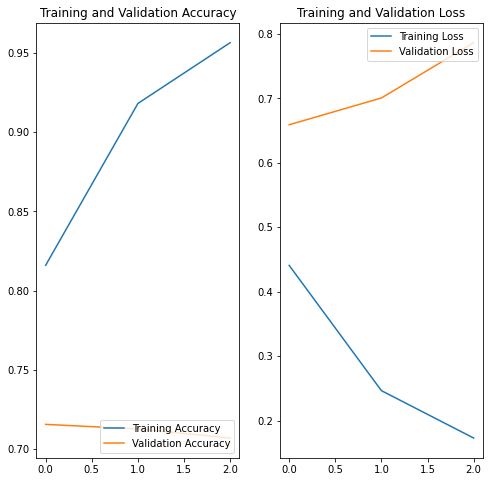

In [46]:
evaluate_model(history)

In [ ]:
classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
last_conv_layer_name = 'block7d_add'

def convert_to_img_array(img_path):
    # img is a PIL image
    img = load_img(img_path,
                   target_size=target_size)
    
    # Convert to float32 Numpy array
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    # img_array = img_array.reshape((-1, img_width, img_height, 3))

    # We add a dimension to transform our array into a "batch"
    # img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [ ]:
classifier_layer_names = ['top_conv', 'top_bn', 'top_activation', 'global_average_pooling2d_1', 'dropout_1', 'dense_3', 'dense_4', 'dense_5']
last_conv_layer_name = 'block7d_add'

img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'

img = load_img(img_path,
               target_size=target_size)

img               = img_to_array(img)
# img               = preprocess_input(img)
y_pred            = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
# topNclass         = 5
# for i, idx in enumerate(class_idxs_sorted[:topNclass]):
#     print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
#           i + 1,classlabel[idx],idx,y_pred[0,idx]))

# Utility to search for layer index by name. 
# ***********  Alternatively we can specify this as -1 since it corresponds to the last layer.  ***************
layer_idx = utils.find_layer_idx(model, 'dense_8')
# Swap softmax with linear
model.layers[layer_idx].activation = tf.keras.activations.linear
model = utils.apply_modifications(model)

penultimate_layer_idx = utils.find_layer_idx(model, "top_conv") 
class_idx  = class_idxs_sorted[0]
seed_input = img
grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx) # TRY TO LEAVE BLANK? -> OR AS 'none'?
                          #  backprop_modifier     = None)
                          #  grad_modifier         = None)

In [ ]:
print(scipy.__version__)

In [ ]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet", alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))

In [ ]:
img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'
plot_map(grad_top1)

# testing_img = select_testing_image()
# run_diagnosis(model, testing_img)